In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import tensorrt

In [2]:
import torch.onnx
from torchvision import datasets, transforms

In [3]:
from mnist import Net

In [4]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
dataset = datasets.MNIST('./data', train=False, transform=transform)

In [5]:
len(dataset)

10000

In [43]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1200, pin_memory=True, shuffle=False, num_workers=2)

In [44]:
a, b = next(iter(dataloader))

In [45]:
a.shape, b.shape

(torch.Size([1200, 1, 28, 28]), torch.Size([1200]))

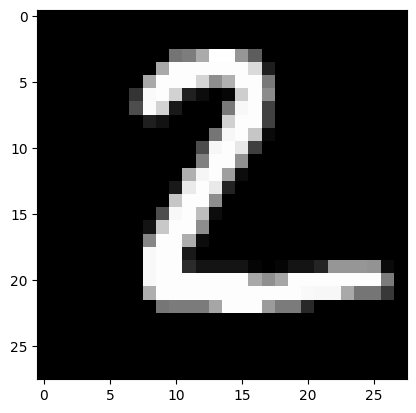

In [46]:
plt.figure()
plt.imshow(a.numpy()[1][0], cmap='gray')
plt.show()

In [10]:
net = Net()

In [11]:
net.load_state_dict(torch.load('mnist_cnn.pt'))

<All keys matched successfully>

In [12]:
net.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [13]:
x = torch.randn(1, 1, 28, 28, requires_grad=True)

In [14]:
out = net(x)

In [15]:
torch.onnx.export(net, x, 'mnist.onnx', export_params=True, opset_version=10, do_constant_folding=True,
                  input_names=['input'], output_names= ['output'],)

In [16]:
import onnx

In [17]:
onnx_model = onnx.load('mnist.onnx')
onnx.checker.check_model(onnx_model)

In [47]:
import tritonclient.http as httpclient

In [48]:
a.shape

torch.Size([1200, 1, 28, 28])

In [49]:
triton_client = httpclient.InferenceServerClient(url="localhost:8000")

In [50]:
test_input = httpclient.InferInput("input", a.numpy().shape, datatype="FP32")

In [51]:
test_input.set_data_from_numpy(a.numpy(), binary_data=True)

In [52]:
test_output = httpclient.InferRequestedOutput("output", binary_data=True)

In [53]:
test_output

In [54]:
results = triton_client.infer(model_name="mnist_onnx", inputs=[test_input], outputs=[test_output])

InferenceServerException: [400] [request id: <id_unknown>] unexpected shape for input 'input' for model 'mnist_onnx'. Expected [1000,1,28,28], got [1200,1,28,28]. 

In [19]:
output_final = results.as_numpy('output')

In [28]:
output_final.shape

(1000, 10)

In [30]:
outputs_np = np.argmax(output_final, axis=1)

In [31]:
outputs_np[:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

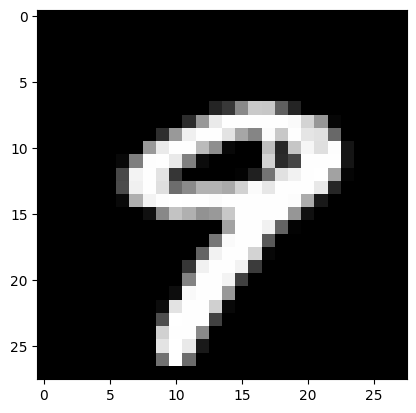

In [41]:
plt.figure()
plt.imshow(a.numpy()[9][0], cmap='gray')
plt.show()